In [1]:
# Download & Extract RAVDESS (Speech Only)
import os, requests, zipfile

# Target folder
DATA_DIR = "./data/RAVDESS"
os.makedirs(DATA_DIR, exist_ok=True)

# Zenodo direct link for RAVDESS speech audio (approx 215 MB)
url = "https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip?download=1"
zip_path = "./data/Audio_Speech_Actors_01-24.zip"

# Download if not already present
if not os.path.exists(zip_path):
    print("Downloading RAVDESS speech dataset (~215MB)...")
    r = requests.get(url, stream=True)
    with open(zip_path, "wb") as f:
        for chunk in r.iter_content(chunk_size=1024*1024):
            if chunk:
                f.write(chunk)
    print("Download complete:", zip_path)
else:
    print("ZIP already exists:", zip_path)

# Extract if not already extracted
if not os.listdir(DATA_DIR):
    print("Extracting ZIP to", DATA_DIR)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(DATA_DIR)
    print("Extraction complete.")
else:
    print("RAVDESS data already extracted at", DATA_DIR)


Download complete: ./data/Audio_Speech_Actors_01-24.zip
Extracting ZIP to ./data/RAVDESS
Extraction complete.


In [7]:
# Emotion Classification Project (RAVDESS)
#Imports & Settings
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import soundfile as sf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from glob import glob
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Plot settings
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 4)

In [8]:
# Utility - parse filenames to get emotion labels (RAVDESS filename format)
# RAVDESS filenames: '03-01-01-01-01-01-01.wav' etc. 
# Field 3 (emotion) mapping (RAVDESS):
# 1 = neutral, 2 = calm, 3 = happy, 4 = sad, 5 = angry, 6 = fearful, 7 = disgust, 8 = surprised
#
EMOTION_MAP = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}

def parse_ravdess_filename(fn):
    # returns emotion label and actor id
    basename = os.path.basename(fn)
    parts = basename.replace('.wav','').split('-')
    emotion_code = parts[2]
    actor = parts[-1]  # actor id in RAVDESS is final segment like '01'
    return EMOTION_MAP.get(emotion_code, "unknown"), actor

# Quick sanity check (if folder exists)
sample_files = glob(os.path.join(DATA_DIR, '**', '*.wav'), recursive=True)[:5]
sample_files


['./data/RAVDESS\\Actor_01\\03-01-01-01-01-01-01.wav',
 './data/RAVDESS\\Actor_01\\03-01-01-01-01-02-01.wav',
 './data/RAVDESS\\Actor_01\\03-01-01-01-02-01-01.wav',
 './data/RAVDESS\\Actor_01\\03-01-01-01-02-02-01.wav',
 './data/RAVDESS\\Actor_01\\03-01-02-01-01-01-01.wav']

In [9]:
# Preprocessing function (Part 2)
# - Loads audio via librosa
# - Resamples to target_sr (16k)
# - Converts to mono
# - Trims silence
# - Normalizes amplitude (peak normalize)
# Returns waveform (numpy array) and sr
TARGET_SR = 16000

def load_preprocess(path, target_sr=TARGET_SR, trim=True, top_db=20):
    # load
    y, sr = librosa.load(path, sr=target_sr, mono=True)
    # optional trim silence
    if trim:
        y, _ = librosa.effects.trim(y, top_db=top_db)
    # normalize (peak)
    max_amp = np.max(np.abs(y)) if y.size else 1.0
    if max_amp > 0:
        y = y / max_amp
    return y, sr

# Test sample
if sample_files:
    y, sr = load_preprocess(sample_files[0])
    print("Loaded ", sample_files[0], "->", y.shape, "sr:", sr)


Loaded  ./data/RAVDESS\Actor_01\03-01-01-01-01-01-01.wav -> (19968,) sr: 16000


In [10]:
# Feature extraction functions (Part 3)
# - MFCC (return mean + std across time as fixed-length vector)
# - Mel-spectrogram (return log-mel spectrogram for CNN)
# - Chroma features
#
def extract_mfcc(y, sr, n_mfcc=40, hop_length=512, n_fft=2048):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft)
    # aggregate: mean and std along time axis
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std = np.std(mfcc, axis=1)
    feature_vector = np.concatenate([mfcc_mean, mfcc_std])
    return feature_vector

def extract_melspectrogram(y, sr, n_mels=128, hop_length=512, n_fft=2048):
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    S_db = librosa.power_to_db(S, ref=np.max)
    return S_db  # shape (n_mels, time_frames)

def extract_chroma(y, sr, hop_length=512, n_fft=2048):
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    chroma_mean = np.mean(chroma, axis=1)
    chroma_std = np.std(chroma, axis=1)
    return np.concatenate([chroma_mean, chroma_std])

In [11]:
# Build metadata & extract baseline features (MFCC) 
# prepare a pandas DataFrame with: file, emotion, actor, mfcc_features (vector)
# For CNN, we'll store a mel-spectrogram file (or keep array in memory - careful with RAM).
#
files = glob(os.path.join(DATA_DIR, '**', '*.wav'), recursive=True)
print("Found {} WAV files".format(len(files)))

rows = []
for fp in tqdm(files, desc="Processing audio files"):
    try:
        emotion, actor = parse_ravdess_filename(fp)
        y, sr = load_preprocess(fp)
        if y.size == 0:
            continue
        mfcc_feat = extract_mfcc(y, sr, n_mfcc=40)
        chroma_feat = extract_chroma(y, sr)
        # optionally also store mel-spectrogram for later CNN
        mel_spec = extract_melspectrogram(y, sr, n_mels=128)
        rows.append({
            'file': fp,
            'emotion': emotion,
            'actor': actor,
            'mfcc': mfcc_feat,
            'chroma': chroma_feat,
            'mel': mel_spec
        })
    except Exception as e:
        print("Error on", fp, e)

df = pd.DataFrame(rows)
df['emotion'].value_counts()


Found 1440 WAV files


Processing audio files: 100%|██████████████████████████████████████████████████████| 1440/1440 [00:44<00:00, 32.57it/s]


emotion
calm         192
happy        192
sad          192
angry        192
fearful      192
disgust      192
surprised    192
neutral       96
Name: count, dtype: int64

In [12]:
# Prepare labels and train/test split (Part 5: Evaluation)
# Choose a subset of emotions to simplify to common 4: neutral, happy, sad, angry (optional)
selected_emotions = ['neutral', 'happy', 'sad', 'angry']
df = df[df['emotion'].isin(selected_emotions)].reset_index(drop=True)
print("After filtering for {} emotions: {} samples".format(selected_emotions, len(df)))

# Encode labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['emotion'])  # e.g. neutral->0, happy->1...
label_map = dict(zip(le.classes_, le.transform(le.classes_)))
label_map


After filtering for ['neutral', 'happy', 'sad', 'angry'] emotions: 672 samples


{'angry': 0, 'happy': 1, 'neutral': 2, 'sad': 3}

In [13]:
# Baseline ML - Random Forest on MFCC features (Part 4 baseline)
# Prepare feature matrix
X_mfcc = np.stack(df['mfcc'].values)
y = df['label'].values

# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(X_mfcc, y, test_size=0.2, random_state=SEED, stratify=y)

# Standardize (fit on train)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train RandomForest
rf = RandomForestClassifier(n_estimators=200, random_state=SEED, n_jobs=-1)
rf.fit(X_train_scaled, y_train)

# Evaluate
y_pred_rf = rf.predict(X_test_scaled)
print("RandomForest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification report:\n", classification_report(y_test, y_pred_rf, target_names=le.classes_))


RandomForest Accuracy: 0.7111111111111111
Classification report:
               precision    recall  f1-score   support

       angry       0.83      0.89      0.86        38
       happy       0.73      0.56      0.64        39
     neutral       0.64      0.47      0.55        19
         sad       0.62      0.79      0.70        39

    accuracy                           0.71       135
   macro avg       0.71      0.68      0.69       135
weighted avg       0.71      0.71      0.70       135



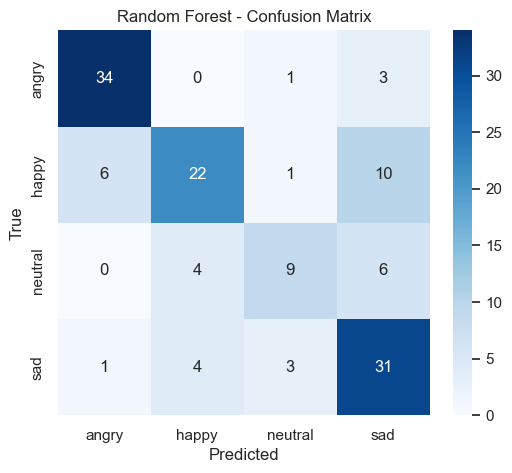

In [14]:
# Cell 8: Confusion matrix for RF
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Random Forest - Confusion Matrix")
plt.show()


In [15]:
# Prepare data for CNN on Mel-spectrograms 
# - Resize/pad spectrograms to a fixed shape (n_mels=128, time_frames=128)
# - Normalize per-sample to [0,1] or per-dataset standardization
# - Train a small Conv2D network on these images (single channel)
# Note: spectrograms shapes vary in time dimension. We'll center-pad or truncate to fixed 'time' length.

TARGET_TIME_FRAMES = 128  # adjust depending on typical audio length/time resolution

def pad_spec(spec, max_len=TARGET_TIME_FRAMES):
    # spec shape: (n_mels, time_frames)
    n_mels, t = spec.shape
    if t < max_len:
        pad_width = max_len - t
        left = pad_width // 2
        right = pad_width - left
        spec_padded = np.pad(spec, ((0,0),(left,right)), mode='constant', constant_values=(spec.min(),))
    elif t > max_len:
        # center crop
        start = (t - max_len) // 2
        spec_padded = spec[:, start:start+max_len]
    else:
        spec_padded = spec
    return spec_padded

# Build arrays
X_mel = []
for s in df['mel'].values:
    X_mel.append(pad_spec(s, TARGET_TIME_FRAMES))
X_mel = np.stack(X_mel)  # shape (N, n_mels, TARGET_TIME_FRAMES)
# Add channel dimension for CNN
X_mel = X_mel[..., np.newaxis]  # (N, n_mels, t, 1)
print("X_mel shape:", X_mel.shape)

# Split matching indices - reuse stratified split indices from MFCC split to ensure fair comparison
# re-create the same split with sklearn to be consistent
X_train_mel, X_test_mel, y_train_mel, y_test_mel = train_test_split(X_mel, y, test_size=0.2, random_state=SEED, stratify=y)


X_mel shape: (672, 128, 128, 1)


In [16]:
#Simple CNN model (Keras) for Mel-spectrogram classification
input_shape = X_train_mel.shape[1:]  # (n_mels, time, 1)
num_classes = len(le.classes_)

def build_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(16, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dropout(0.4),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_cnn_model(input_shape, num_classes)
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 16)        │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       1,048,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,072,900 (4.09 MB)

 Trainable params: 1,072,548 (4.09 MB)

 Non-trainable params: 352 (1.38 KB)

In [17]:
#Train CNN 
EPOCHS = 40
BATCH_SIZE = 32

es = callbacks.EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True)
mc = callbacks.ModelCheckpoint('best_mel_cnn.h5', monitor='val_accuracy', save_best_only=True)

history = model.fit(
    X_train_mel, y_train_mel,
    validation_split=0.15,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es, mc],
    verbose=1
)


Epoch 1/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.3394 - loss: 1.8641

15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 269ms/step - accuracy: 0.3434 - loss: 1.8454 - val_accuracy: 0.3086 - val_loss: 6.9548
Epoch 2/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 248ms/step - accuracy: 0.6945 - loss: 0.9022 - val_accuracy: 0.3086 - val_loss: 4.2662
Epoch 3/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 245ms/step - accuracy: 0.7158 - loss: 0.7246 - val_accuracy: 0.3086 - val_loss: 3.2339
Epoch 4/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step - accuracy: 0.8329 - loss: 0.5308 - val_accuracy: 0.3086 - val_loss: 2.2808
Epoch 5/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.8647 - loss: 0.4051

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 224ms/step - accuracy: 0.8649 - loss: 0.4042 - val_accuracy: 0.3210 - val_loss: 1.5794
Epoch 6/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.9125 - loss: 0.3265

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 224ms/step - accuracy: 0.9139 - loss: 0.3237 - val_accuracy: 0.3457 - val_loss: 1.3943
Epoch 7/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.9599 - loss: 0.2121

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step - accuracy: 0.9598 - loss: 0.2117 - val_accuracy: 0.3951 - val_loss: 1.3280
Epoch 8/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.9507 - loss: 0.2153

15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - accuracy: 0.9510 - loss: 0.2138 - val_accuracy: 0.4938 - val_loss: 1.1515
Epoch 9/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.9629 - loss: 0.1624

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 223ms/step - accuracy: 0.9636 - loss: 0.1616 - val_accuracy: 0.5556 - val_loss: 1.0864
Epoch 10/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.9810 - loss: 0.1434

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 224ms/step - accuracy: 0.9812 - loss: 0.1422 - val_accuracy: 0.6296 - val_loss: 1.0020
Epoch 11/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - accuracy: 0.9849 - loss: 0.1166 - val_accuracy: 0.5802 - val_loss: 1.0691
Epoch 12/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step - accuracy: 0.9787 - loss: 0.1019 - val_accuracy: 0.5802 - val_loss: 0.9316
Epoch 13/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 221ms/step - accuracy: 1.0000 - loss: 0.0583 - val_accuracy: 0.5802 - val_loss: 0.9499
Epoch 14/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - accuracy: 0.9878 - loss: 0.0766 - val_accuracy: 0.6173 - val_loss: 0.9158
Epoch 15/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.9850 - loss: 0.0748

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 223ms/step - accuracy: 0.9854 - loss: 0.0740 - val_accuracy: 0.6543 - val_loss: 0.8790
Epoch 16/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - accuracy: 0.9955 - loss: 0.0581 - val_accuracy: 0.6420 - val_loss: 0.9388
Epoch 17/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 267ms/step - accuracy: 0.9991 - loss: 0.0473 - val_accuracy: 0.5679 - val_loss: 1.0343
Epoch 18/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 245ms/step - accuracy: 0.9983 - loss: 0.0428 - val_accuracy: 0.5802 - val_loss: 1.1130
Epoch 19/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - accuracy: 0.9921 - loss: 0.0538 - val_accuracy: 0.6049 - val_loss: 0.9108
Epoch 20/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - accuracy: 0.9941 - loss: 0.0429 - val_accuracy: 0.5185 - val_loss: 1.3012
Epoch 21/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.9934 - loss: 0.0357 - val_accuracy: 0.5185 - val_loss: 1.1544


In [18]:
# Cell 12: Evaluate CNN
cnn_eval = model.evaluate(X_test_mel, y_test_mel, verbose=1)
print("CNN Test loss, accuracy:", cnn_eval)

y_pred_cnn = np.argmax(model.predict(X_test_mel), axis=1)
print("CNN Classification report:\n", classification_report(y_test_mel, y_pred_cnn, target_names=le.classes_))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6625 - loss: 0.8576
CNN Test loss, accuracy: [0.8301296234130859, 0.6814814805984497]
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step 
CNN Classification report:
               precision    recall  f1-score   support

       angry       0.67      0.95      0.78        38
       happy       0.77      0.59      0.67        39
     neutral       0.78      0.37      0.50        19
         sad       0.62      0.67      0.64        39

    accuracy                           0.68       135
   macro avg       0.71      0.64      0.65       135
weighted avg       0.70      0.68      0.67       135



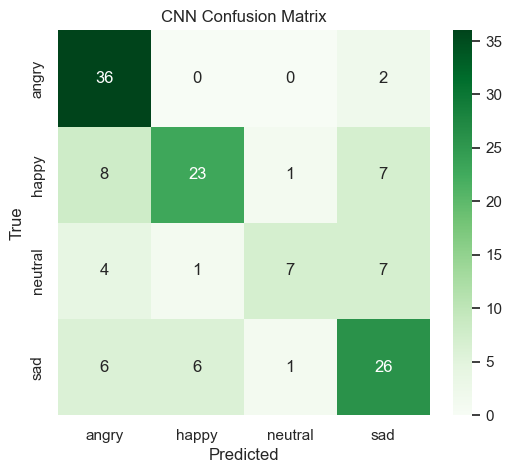

In [19]:
#Confusion matrix for CNN 
cm_cnn = confusion_matrix(y_test_mel, y_pred_cnn)
plt.figure(figsize=(6,5))
sns.heatmap(cm_cnn, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Greens')
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


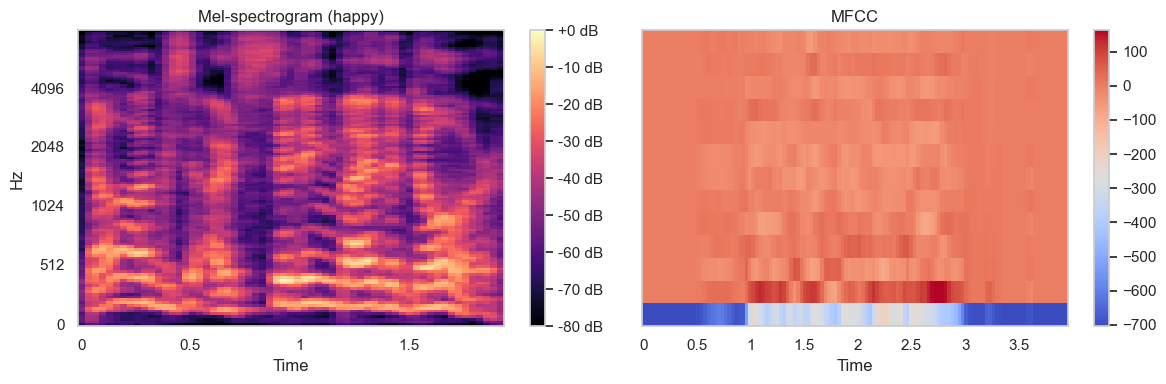

In [20]:
#Visualizations - example spectrograms & MFCCs (deliverable visualizations)
# Show a mel-spectrogram and MFCC heatmap for a sample
sample_idx = 10
spec = df.loc[sample_idx, 'mel']
mfcc_raw = librosa.feature.mfcc(y=librosa.load(df.loc[sample_idx,'file'], sr=TARGET_SR, mono=True)[0], sr=TARGET_SR, n_mfcc=13)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
librosa.display.specshow(spec, sr=TARGET_SR, hop_length=512, x_axis='time', y_axis='mel')
plt.title(f"Mel-spectrogram ({df.loc[sample_idx,'emotion']})")
plt.colorbar(format='%+2.0f dB')

plt.subplot(1,2,2)
librosa.display.specshow(mfcc_raw, sr=TARGET_SR, x_axis='time')
plt.title("MFCC")
plt.colorbar()
plt.tight_layout()
plt.show()


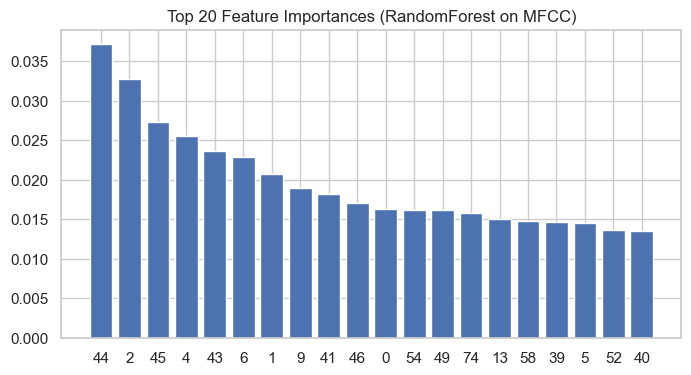

In [21]:
#Feature importance for RandomForest 
importances = rf.feature_importances_
# We used 40 mfcc means + 40 stds => length 80
# Plot top 20 importances
indices = np.argsort(importances)[::-1][:20]
plt.figure(figsize=(8,4))
plt.bar(range(len(indices)), importances[indices])
plt.xticks(range(len(indices)), indices)
plt.title("Top 20 Feature Importances (RandomForest on MFCC)")
plt.show()


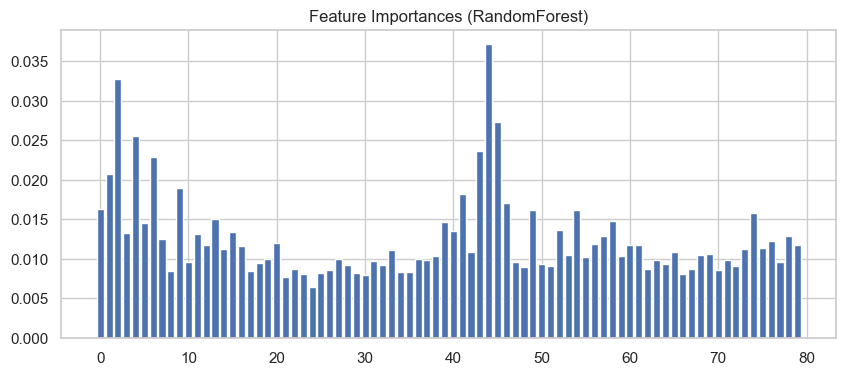

In [23]:
importances = rf.feature_importances_
plt.bar(range(len(importances)), importances)
plt.title("Feature Importances (RandomForest)")
plt.show()


In [22]:
# Cell 16: Quick report summary template (you can paste into your report)
report_summary = f"""
Project: Emotion classification using RAVDESS (Selected emotions: {', '.join(selected_emotions)})
Dataset size: {len(df)} samples after filtering.
Baseline: RandomForest on MFCC features -> Accuracy: {accuracy_score(y_test, y_pred_rf):.3f}
Advanced: CNN on Mel-spectrogram -> Accuracy: {cnn_eval[1]:.3f}

Observations:
- Deep CNN on spectrograms typically outperforms classical baseline when dataset size & time-alignment are sufficient.
- MFCC-based RandomForest is quick, interpretable, and a good baseline for small datasets.
- Challenges: small dataset size per-class, overfitting (use augmentation), varying audio durations.

Next steps (suggestions to improve accuracy & hiring-worthiness):
1. Data augmentation (time-shift, pitch shift, additive noise, SpecAugment).
2. Use transfer learning (pretrained audio CNNs like VGGish or PANNs).
3. Speaker-normalization or actor-wise CV (leave-one-actor-out CV).
4. Ensembling classical + deep models.
"""
print(report_summary)



Project: Emotion classification using RAVDESS (Selected emotions: neutral, happy, sad, angry)
Dataset size: 672 samples after filtering.
Baseline: RandomForest on MFCC features -> Accuracy: 0.711
Advanced: CNN on Mel-spectrogram -> Accuracy: 0.681

Observations:
- Deep CNN on spectrograms typically outperforms classical baseline when dataset size & time-alignment are sufficient.
- MFCC-based RandomForest is quick, interpretable, and a good baseline for small datasets.
- Challenges: small dataset size per-class, overfitting (use augmentation), varying audio durations.

Next steps (suggestions to improve accuracy & hiring-worthiness):
1. Data augmentation (time-shift, pitch shift, additive noise, SpecAugment).
2. Use transfer learning (pretrained audio CNNs like VGGish or PANNs).
3. Speaker-normalization or actor-wise CV (leave-one-actor-out CV).
4. Ensembling classical + deep models.



In [24]:
# Cell 17: Optional - Streamlit app scaffold (Part 6)
# Save this content to a file streamlit_app.py and run: streamlit run streamlit_app.py
streamlit_app = r'''
import streamlit as st
import numpy as np
import librosa
from tensorflow.keras.models import load_model
import soundfile as sf

MODEL_PATH = "best_mel_cnn.h5"  # ensure trained model saved here

st.title("Emotion Classifier (RAVDESS-trained)")
st.write("Upload a WAV file (speech). Will predict emotion among: neutral, happy, sad, angry.")

uploaded_file = st.file_uploader("Upload WAV", type=["wav"])
if uploaded_file is not None:
    # Save to temp and process
    with open("temp.wav", "wb") as f:
        f.write(uploaded_file.getbuffer())
    y, sr = librosa.load("temp.wav", sr=16000, mono=True)
    # preprocess similarly as in notebook
    y, _ = librosa.effects.trim(y)
    y = y / max(abs(y)) if max(abs(y))>0 else y
    # extract mel
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_db = librosa.power_to_db(S, ref=np.max)
    # pad or crop to 128 frames
    import numpy as np
    def pad_spec(spec, max_len=128):
        n_mels, t = spec.shape
        if t < max_len:
            pad_width = max_len - t
            left = pad_width // 2
            right = pad_width - left
            spec_padded = np.pad(spec, ((0,0),(left,right)), mode='constant', constant_values=(spec.min(),))
        elif t > max_len:
            start = (t - max_len) // 2
            spec_padded = spec[:, start:start+max_len]
        else:
            spec_padded = spec
        return spec_padded
    S_p = pad_spec(S_db, 128)
    X = S_p[np.newaxis, ..., np.newaxis]  # shape (1, n_mels, time, 1)
    model = load_model(MODEL_PATH)
    pred = np.argmax(model.predict(X), axis=1)[0]
    label_map = {0:"neutral", 1:"happy", 2:"sad", 3:"angry"}  # set accordingly to your label encoding
    st.write("Predicted emotion:", label_map.get(pred, "unknown"))
'''
with open("streamlit_app.py", "w") as f:
    f.write(streamlit_app)
print("Streamlit scaffold saved to streamlit_app.py. Run with: streamlit run streamlit_app.py")

Streamlit scaffold saved to streamlit_app.py. Run with: streamlit run streamlit_app.py
